# 타이타닉 생존 여부 예측

#### 변수 설명
* pclass : 1, 2, 3등석 
* survived : 생존 여부. survived(생존-1), dead(사망-0)
* name : 이름
* sex : female(여성), male(남성)
* age : 나이
* sibsp : 함께 탑승한 형제 또는 배우자의 수
* parch : 함께 탑승한 부모 또는 자녀의 수
* ticket : 티켓 번호
* fare : 티켓 요금
* cabin : 선실 번호
* embarked :탑승한 곳. C(Cherbourg), Q(Queenstown), S(Southampton)

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
%matplotlib inline

plt.rcParams['font.family'] = 'AppleGothic' # 폰트 변경
plt.rcParams['axes.unicode_minus'] = False # 축 값 마이너스 깨짐 해결

### 전처리

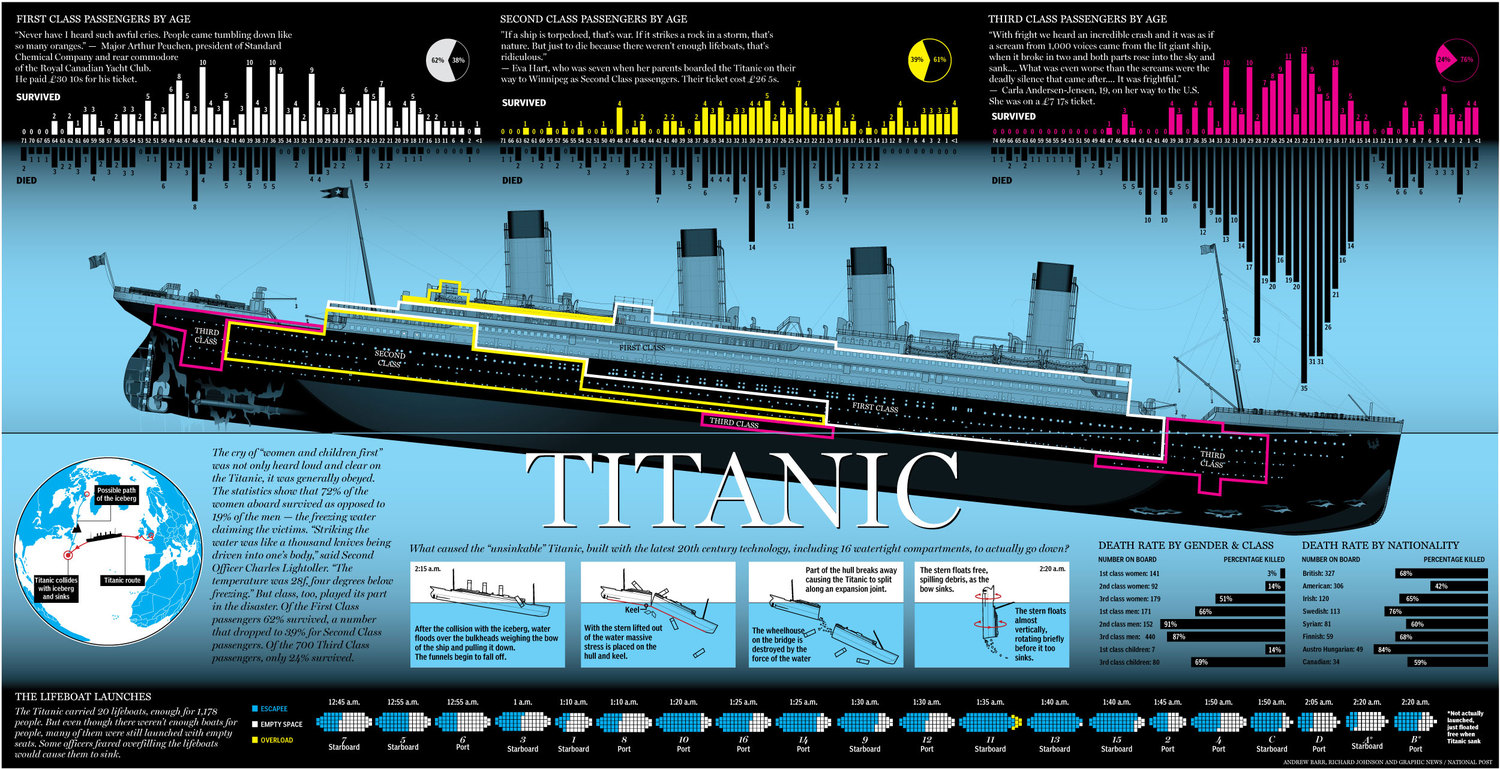

In [38]:
# 참고용 사진
Image.open('TItanic-Survival-Infographic.jpeg')

In [39]:
train_df = pd.read_csv('../ml/data/titanic/train.csv')
test_df = pd.read_csv('../ml/data/titanic/test.csv')

In [40]:
print(train_df.shape)
print(test_df.shape)

(891, 12)
(418, 11)


In [41]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:>

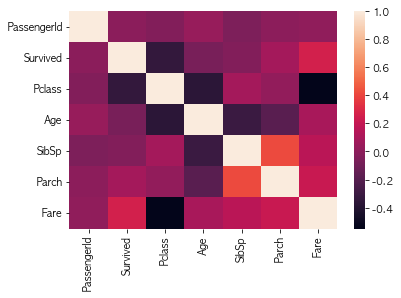

In [42]:
sns.heatmap(train_df.corr())

<AxesSubplot:>

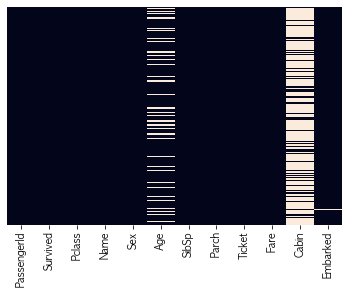

In [43]:
# max => 891, row의 수가 891 이하는 결측치로 판단
sns.heatmap(train_df.isnull(), yticklabels=False,cbar=False)

/opt/homebrew/Caskroom/miniforge/base/envs/sesac/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


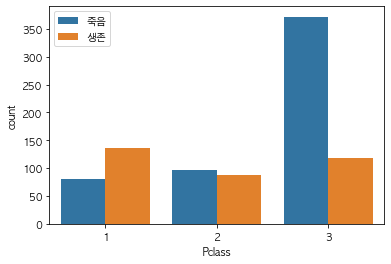

In [44]:
sns.countplot(train_df['Pclass'], hue=train_df['Survived'])
plt.legend(labels=['죽음','생존'])
plt.show()

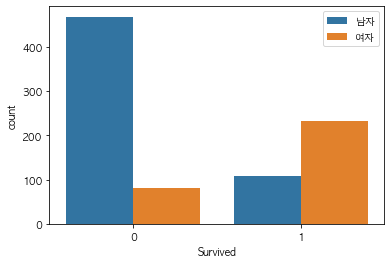

In [45]:
# 성별단위 생존여부 확인 ( 0이 죽음, 1이 생존 )
sns.countplot(data=train_df, x='Survived', hue='Sex')
plt.legend(['남자','여자'])
plt.show()

In [46]:
# 나이 결측치를 최빈값으로 대체
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].value_counts().index[0])
train_df['Age'].isnull().sum()

0

/opt/homebrew/Caskroom/miniforge/base/envs/sesac/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


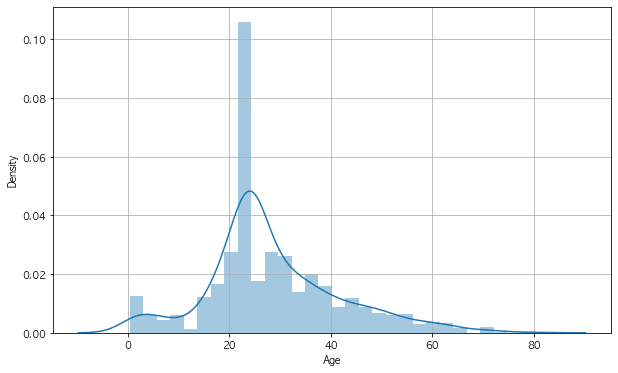

In [47]:
# 나이별 분포 확인
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(train_df['Age'], bins=30, ax=ax)
plt.grid()
plt.show()

In [48]:
# 비슷한 성향의 호칭은 통합
# idea from CORAZON17 
def convert_title(title):
    if title in ["Ms", "Mlle", "Miss"]:
        return "Miss"
    elif title in ["Mme", "Mrs", "Countess", "Lady", "Dona"]:
        return "Mrs"
    elif title in ["Mr", "Major", "Col", "Capt", "Sir", "Don", "Jonkheer"]:
        return "Mr"
    else :
        return title

In [49]:
def trans_titanic_df(df):
    df['Title'] = df['Name'].apply(lambda x : x.split(',')[1].split('.')[0].strip())
    
    # 나이 결측치를 최빈값으로 대체
    df['Age'] = df['Age'].fillna(train_df['Age'].value_counts().index[0])
    
    df['Fare'] = df['Fare'].fillna(train_df['Age'].value_counts().index[0])
    
    df['Age_cat'] = pd.cut(df['Age'], bins=[0,3,7,15,30,60,100], include_lowest=True, #첫째 간격의 왼쪽 포함 여부
                    labels = ['baby', 'children', 'teenage', 'young',' adult', 'old'])
    
    df['Sex'] = df['Sex'].apply(lambda x : 0 if x == 'male' else 1)
    
    df['Title'] = df['Title'].apply(convert_title)
    return df

In [50]:
train_df_1 = trans_titanic_df(train_df)
test_df_1 = trans_titanic_df(test_df)


In [51]:
# PassengerId, Survived, Name, Age, Ticket, Carbin, Embarked 제외한 나머지 컬럼으로 training
X_train = train_df_1.loc[:,['Pclass','Sex', 'SibSp', 'Parch', 'Fare', 'Title', 'Age_cat']]
label = train_df_1.loc[:,['Survived']]
test = test_df_1.loc[:,['Pclass','Sex', 'SibSp', 'Parch', 'Fare', 'Title', 'Age_cat']]

In [52]:
test = test[test['Fare'].notnull()]

In [53]:
print(X_train.shape, label.shape, test.shape)

(891, 7) (891, 1) (418, 7)


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [55]:
x_train, x_test, y_train, y_test = train_test_split(X_train, label, test_size=0.2, random_state=123)

In [56]:
numeric_features = ['Fare']
numeric_transformer = StandardScaler()

# 범주형 변수 열 입력
categorical_features = ['Pclass','Sex', 'SibSp', 'Parch', 'Title', 'Age_cat']
categorical_transformer = OneHotEncoder(categories='auto', handle_unknown='ignore') # 범주형 데이터가 x_train, x_test에 고르게 들어가지 않는 경우 pass 하기 위해 handel_unknown param ='ignore' 로 설정

In [57]:
preprocessor = ColumnTransformer(transformers=[ # List of (name, transformer, column(s))
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

In [58]:
preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)]) # 파이프라인 단계 입력

preprocessor_pipe.fit(x_train, x_test) # 변수 변환

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Fare']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Title',
                                                   'Age_cat'])]))])

In [59]:
x_train_transformed = preprocessor_pipe.transform(x_train)
x_test_transformed = preprocessor_pipe.transform(x_test)

In [60]:
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train_transformed, y_train)
print(f' Train Set 점수 : {rf_clf.score(x_train_transformed, y_train):.2f}')
y_pred = rf_clf.predict(x_test_transformed)
print(f' Test Set 점수 : {rf_clf.score(x_test_transformed, y_test):.2f}')

 Train Set 점수 : 0.94
 Test Set 점수 : 0.83


/var/folders/6b/s1063_qj51s2xh9qm5l7ntq40000gn/T/ipykernel_26835/3959591899.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(x_train_transformed, y_train)


In [61]:
test_transformed = preprocessor_pipe.transform(test)
y_pred = rf_clf.predict(test_transformed)

In [62]:
f_test = pd.DataFrame()
f_test['PassengerId'] = test_df_1['PassengerId']
f_test['Survived'] = y_pred
f_test['Survived'].value_counts()
f_test.to_csv('kaggle.csv', encoding='utf-8-sig', index=False)

## 2차 시도(점수 갱신)

In [ ]:
from vecstack import StackingTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [64]:
print(x_train_transformed.shape)
print(y_train.shape)

(712, 32)
(712, 1)


In [ ]:
estimators = [ 
('KNN', KNeighborsClassifier(n_neighbors=10)),
('SupportVectorClasscification', SVC(C=0.01)),
('RandomForest', RandomForestClassifier(n_estimators=250))]

stack = StackingTransformer(estimators, regression = False, 
                        metric = accuracy_score, 
                        n_folds = 10, stratified = True, shuffle = True, 
                        random_state = 123, verbose = 0)

stack.fit(x_train_transformed, y_train)
S_train = stack.transform(x_train_transformed)
S_test = stack.transform(x_test_transformed)

model = SGDClassifier(alpha=0.01) 
model = model.fit(S_train, y_train) 
    

In [69]:
stack_test = stack.transform(test_transformed)
y_pred = model.predict(stack_test)

/opt/homebrew/Caskroom/miniforge/base/envs/sesac/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/homebrew/Caskroom/miniforge/base/envs/sesac/lib/python3.8/site-packages/vecstack/coresk.py:776: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the v

In [70]:
stack_test = pd.DataFrame()
stack_test['PassengerId'] = test_df_1['PassengerId']
stack_test['Survived'] = y_pred
stack_test.to_csv('kaggle_stacking.csv', encoding='utf-8-sig', index=False)